<a href="https://colab.research.google.com/github/gazal-gupta/Deep_Learning/blob/master/Project_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Project 3: Spam filter for Quora questions Download data from here : https://www.dropbox.com/sh/kpf9z73woodfssv/AAAw1_JIzpuVvwteJCma0xMla

Goal : Build a model for identifying if a question on Quora is spam

Suggested Guidelines :

To bring down dimensions of your model you can use glove embedding shared with you ( in the data )

Here is how you can use pertained embeddings : https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

You'll have to Create and maintain your own train/validation splits for the full data shared with you

Your solution needs to be uploaded to GitHub repo of your team

In [1]:
!wget https://www.dropbox.com/sh/kpf9z73woodfssv/AAAwZ5DDt-aHwqZFHYrZ-ZBHa/train.csv

--2020-01-10 18:29:23--  https://www.dropbox.com/sh/kpf9z73woodfssv/AAAwZ5DDt-aHwqZFHYrZ-ZBHa/train.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /sh/raw/kpf9z73woodfssv/AAAwZ5DDt-aHwqZFHYrZ-ZBHa/train.csv [following]
--2020-01-10 18:29:23--  https://www.dropbox.com/sh/raw/kpf9z73woodfssv/AAAwZ5DDt-aHwqZFHYrZ-ZBHa/train.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd620311e65ba1f11b4943113d9.dl.dropboxusercontent.com/cd/0/inline/Av4XwquOhDFzZj-JtUKnadJ3kfHEddViglLqmJdJWwSO9gc1cAnoQihnzVCbnR5_guK1qE9zscXV2i9GsNASGIaXJo7bOEOGjKnUJWpGmvXNyA/file# [following]
--2020-01-10 18:29:23--  https://ucd620311e65ba1f11b4943113d9.dl.dropboxusercontent.com/cd/0/inline/Av4XwquOhDFzZj-JtUKnadJ3kfHEddViglLqmJdJWwSO9gc1cAnoQihnzVCb

In [2]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2020-01-10 18:29:36--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-01-10 18:29:36--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-01-10 18:29:36--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [3]:
#unzip the file 
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [5]:
import numpy as np
import pandas as pd
from keras.layers import LSTM,GRU, Activation, Dense, Dropout,Flatten, Input, Embedding
from keras.models import Model

from keras.models import Sequential
from keras.layers.convolutional import Conv1D
from keras.layers import MaxPooling1D , GlobalMaxPooling1D

Using TensorFlow backend.


In [0]:
#store 300 size vector representation different words from the file to a disctionary
embedding_index = {}
f = open('glove.6B.300d.txt',encoding='utf-8')
for line in f:
  value = line.split()
  word = value[0]
  coeffs = np.asarray(value[1:],dtype = 'float32')
  embedding_index[word] = coeffs
f.close()

In [7]:
len(embedding_index)

400000

In [0]:
quora_data = pd.read_csv ("/content/train.csv")# reading csv

In [9]:
quora_data.shape

(1306122, 3)

In [7]:
quora_data.tail(10)

,qid,question_text,target
1306112,ffffa5b0fa76431c063f,Are you ashamed of being an Indian?,1
1306113,ffffae5dbda3dc9e9771,What are the methods to determine fossil ages ...,0
1306114,ffffba7c4888798571c1,What is your story today?,0
1306115,ffffc0c7158658a06fd9,How do I consume 150 gms protein daily both ve...,0
1306116,ffffc404da586ac5a08f,What are the good career options for a msc che...,0
1306117,ffffcc4e2331aaf1e41e,What other technical skills do you need as a c...,0
1306118,ffffd431801e5a2f4861,Does MS in ECE have good job prospects in USA ...,0
1306119,ffffd48fb36b63db010c,Is foam insulation toxic?,0
1306120,ffffec519fa37cf60c78,How can one start a research project based on ...,0
1306121,ffffed09fedb5088744a,Who wins in a battle between a Wolverine and a...,0


In [10]:
quora_data['target'].value_counts()

0    1225312
1      80810
Name: target, dtype: int64

Class 0: 1225312
Class 1: 80810
Proportion: 15.16 : 1


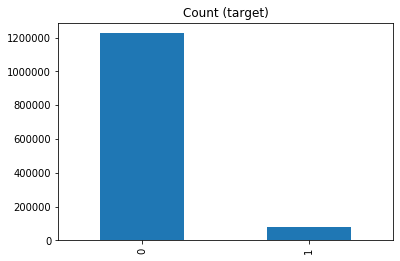

In [11]:
#to check the proportion of the ones to zeros
target_count = quora_data['target'].value_counts()

print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)');

In [0]:
from sklearn.model_selection import train_test_split
q_train , q_test = train_test_split(quora_data, test_size=0.2)

In [13]:
q_train.shape , q_test.shape

((1044897, 3), (261225, 3))

In [0]:
x_train = q_train['question_text']
y_train = q_train['target']
x_test  = q_test['question_text']
y_test  = q_test['target']

In [15]:
x_train.shape , y_train.shape , x_test.shape , y_test.shape

((1044897,), (1044897,), (261225,), (261225,))

In [16]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.layers import LSTM,Activation,Dense,Input,Embedding,Dropout
from keras.models import Model
from nltk import word_tokenize
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
sent_lens=[len(word_tokenize(x)) for x in x_train]

In [18]:
print(word_tokenize(x) for x in x_train)

<generator object <genexpr> at 0x7f6cfdcc5f10>


In [19]:
max(sent_lens)

412

In [20]:
np.percentile(sent_lens,95)

31.0

In [0]:
max_len=31 #taking the 95% quantile value of the sentence length

tk=Tokenizer(char_level=False,split=' ') # tokenizing the sentence 

tk.fit_on_texts(x_train)

seq_train=tk.texts_to_sequences(x_train) # create tokens on train
seq_test=tk.texts_to_sequences(x_test)

vocab_size=len(tk.word_index)

seq_train_matrix=sequence.pad_sequences(seq_train,maxlen=max_len) #padding the sentence with 0
seq_test_matrix=sequence.pad_sequences(seq_test,maxlen=max_len)

In [21]:
seq_train_matrix.shape , seq_test_matrix.shape , vocab_size

((1044897, 30), (261225, 30), 196085)

In [23]:
seq_train_matrix[1]

array([    0,     0,     0,     0,     0,     8,    96,   126,    18,
       16918,   667,    78,    10,   270,   113,   664,   276,     9,
          68,   276,    11,    14,    67,     8,    31,  1530,     5,
        2226,     4, 38366], dtype=int32)

In [0]:
# creating our own embedding matrix to bring down the size to 300
# we'll use 300 D vector representation of the words from pretrained embedding index 
# that we downloaded 

embedding_matrix=np.zeros((vocab_size+1,300))

for word,i in tk.word_index.items():
    embed_vector=embedding_index.get(word)
    if embed_vector is not None:
        embedding_matrix[i]=embed_vector
# if there are specific words which are not present in pretrained embedding 
# their weights will remain 0. if there are too many such words 
# then you should probably not use pretrained embeddings 

Modelling by GRU

In [30]:
inputs=Input(name='text_input',shape=[max_len])
embed=Embedding(vocab_size+1,300,input_length=max_len,mask_zero=True,
                weights=[embedding_matrix],trainable=False)(inputs)
GRU_layer=GRU(50)(embed)
dense1=Dense(10,activation='relu')(GRU_layer)
drop=Dropout(0.2)(dense1)
final_layer=Dense(1,activation='sigmoid')(drop)

model_GRU=Model(inputs=inputs,outputs=final_layer)
model_GRU.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_input (InputLayer)      (None, 30)                0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 30, 300)           58842900  
_________________________________________________________________
gru_2 (GRU)                  (None, 50)                52650     
_________________________________________________________________
dense_7 (Dense)              (None, 10)                510       
_________________________________________________________________
dropout_3 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 11        
Total params: 58,896,071
Trainable params: 53,171
Non-trainable params: 58,842,900
__________________________________________

In [31]:
model_GRU.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [32]:
model_GRU.fit(seq_train_matrix,y_train,validation_data=[seq_test_matrix,y_test],epochs=10,class_weight={0:1,1:12},
          batch_size=10000)



Train on 1044897 samples, validate on 261225 samples
Epoch 1/1
1044897/1044897 [==============================] - 14s 14us/step - loss: 0.7383 - acc: 0.8208 - val_loss: 0.2733 - val_acc: 0.8829


In [33]:
p=model_GRU.predict(seq_test_matrix)
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,p)

0.9372852292072823